In [1]:
# import required libraries
import numpy
import pandas as pd
import time
import datetime
import matplotlib.pyplot as plt
from sklearn import preprocessing
from pkg_resources import resource_filename
from nupic.data.file_record_stream import FileRecordStream
from nupic.frameworks.opf.model_factory import ModelFactory
from IPython.display import clear_output

print("Imported required libraries!")

Imported required libraries!


In [2]:
# fetch and preprocess data
def getData(datasetPath):
    df = pd.read_csv(datasetPath, delimiter=';')
    df = df[['Timestamp','CPU usage [MHZ]','Memory usage [KB]','Disk read throughput [KB/s]','Disk write throughput [KB/s]','Network received throughput [KB/s]','Network transmitted throughput [KB/s]']]
    df.columns = ['timestamp','cpu','ram','read','write','download','upload']
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.loc[-2] = 'datetime','float','float','float','float','float','float'
    df.loc[-1] = 'T','','','','','',''
    df = df.sort_index().reset_index(drop=True)
    df.to_csv(r'data.csv', index = False)
    return FileRecordStream('data.csv')

data = getData("datasets/GWA-T-13_Materna-Workload-Traces/Materna-Trace-1/02.csv")

# load model parameters
from params.cpu import MODEL_PARAMS as CPU_PARAMS
from params.ram import MODEL_PARAMS as RAM_PARAMS
from params.read import MODEL_PARAMS as READ_PARAMS
from params.write import MODEL_PARAMS as WRITE_PARAMS
from params.download import MODEL_PARAMS as DOWN_PARAMS
from params.upload import MODEL_PARAMS as UP_PARAMS

print("Dataset and model parameters are set!")


Dataset and model parameters are set!


In [3]:
# define models and variables
def CreateModel(params, variable):
    model = ModelFactory.create(params)
    model.enableInference({'predictedField': variable})
    return model

cpu_model = CreateModel(CPU_PARAMS,'cpu')
ram_model = CreateModel(RAM_PARAMS, 'ram')
read_model = CreateModel(READ_PARAMS, 'read')
write_model = CreateModel(WRITE_PARAMS, 'write')
download_model = CreateModel(DOWN_PARAMS, 'download')
upload_model = CreateModel(UP_PARAMS, 'upload')

labels = ['cpu','ram','read','write','download','upload']
models = [cpu_model, ram_model, read_model, write_model, download_model, upload_model]
thresholds = [0.9,0.9,0.9,0.9,0.9,0.9]

inputs = [[],[],[],[],[],[]]
predictions = [[],[],[],[],[],[]]
anomalyScores = [[],[],[],[],[],[]]
anomalies = [[],[],[],[],[],[]]

print("Models and variables defined!")


Models and variables defined!


In [4]:
# train all models

j = 0       # record index
n = 6       # number of features being used
m = 500     # total records to process

for j in xrange(m):
#while(data.recordsExistAfter):
    record = dict(zip(data.getFieldNames(), data.next()))
    for i in range(n):
        inputs[i].append(record[labels[i]])
        result = models[i].run(record)
        predictions[i].append(result.inferences["multiStepBestPredictions"][1])
        anomalyScores[i].append(result.inferences["anomalyScore"])
        if(result.inferences["anomalyScore"] > thresholds[i]):
            anomalies[i].append(record[labels[i]])
        else:
            anomalies[i].append(None)
        clear_output(wait=True)
        print(j+1,i+1)

print("Training complete!")

(500, 6)
Training complete!


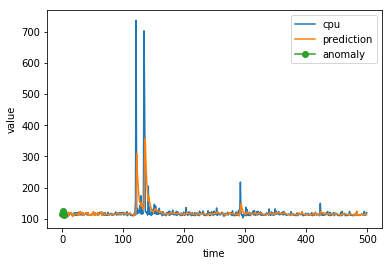

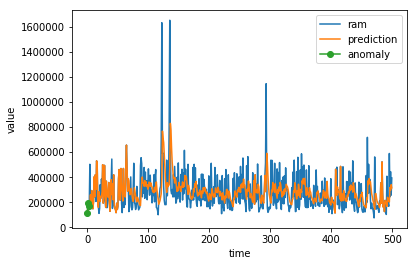

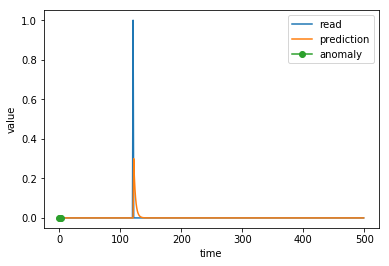

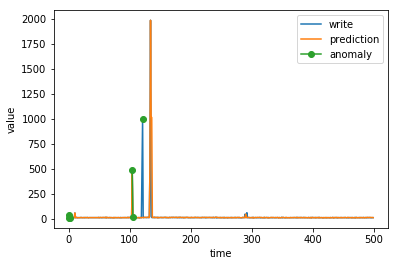

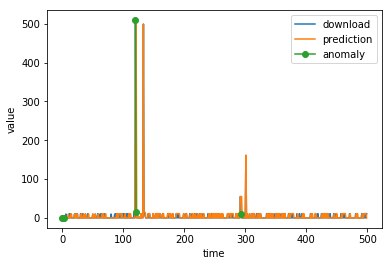

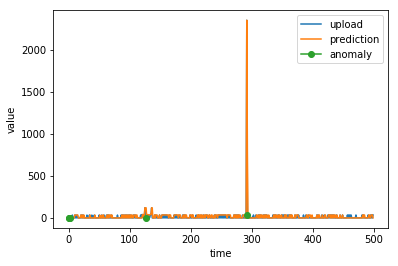

In [5]:
# plot results
for i in range(n):
    plt.plot(inputs[i], label=labels[i])
    plt.plot(predictions[i], label="prediction")
    plt.plot(anomalies[i], label="anomaly", marker="o")
    plt.legend()
    plt.xlabel('time')
    plt.ylabel('value')
    plt.show()

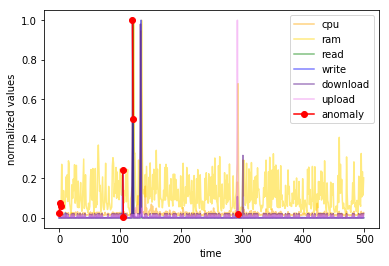

In [6]:
# normalize and scale values to present results in the same graph

nInputs = preprocessing.normalize(inputs)
for i in range(n):
    nInputs[i] = (nInputs[i] - numpy.min(nInputs[i]))/numpy.ptp(nInputs[i])

nAnomalies = []

for j in range(m):
  nAnomalies.append(None)

for i in range(n):
    for j in range(m):
        aVal = None
        for k in range(n):
            if(anomalies[k][j] and (nInputs[k][j] > aVal)):
                aVal = nInputs[k][j]
        if(anomalies[i][j]):
            nAnomalies[j] = aVal

colors = ["orange","gold","green","blue","indigo","violet"]

for i in range(n):
    plt.plot(nInputs[i], label=labels[i], color=colors[i], alpha=0.5)

plt.plot(nAnomalies, label="anomaly", marker="o",color="red")
plt.legend()
plt.xlabel('time')
plt.ylabel('normalized values')
plt.show()

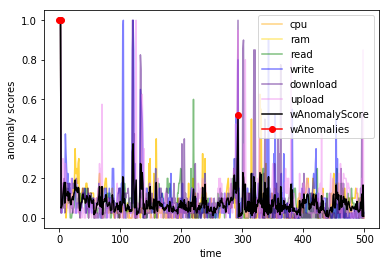

In [7]:
# instead of flagging for each feature's individual anomalies, use a combined weighted average

wat = 0.5       # weighted average threshold
weights = [0.1667,0.1667,0.1667,0.1667,0.1667,0.1667]     # must add up to 1

wAnomalyScore = []
for j in xrange(m):
    val = 0.0
    for i in range(n):
        val = val + (anomalyScores[i][j] * weights[i])
    wAnomalyScore.append(val)

wAnomalies = []

for j in xrange(m):
    if(wAnomalyScore[j] > wat):
        wAnomalies.append(wAnomalyScore[j])
    else:
        wAnomalies.append(None)

for i in range(n):
    plt.plot(anomalyScores[i], label=labels[i], color=colors[i], alpha=0.5)

plt.plot(wAnomalyScore, label="wAnomalyScore",color="black")
plt.plot(wAnomalies, label="wAnomalies",color="red",marker="o")
plt.legend()
plt.xlabel('time')
plt.ylabel('anomaly scores')
plt.show()